# $Yvette$ $WorkBook$

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from sklearn.cluster import KMeans

import wrangle as w

import env

In [2]:
df = w.get_zillow_data()

In [3]:
df= w.zillow_prep(df)

In [4]:
df.shape

(50293, 34)

In [15]:
train, X_train, X_validate, X_test, y_train, y_validate, y_test = w.split(df, 'log_error')

In [16]:
train.shape

(28163, 34)

In [17]:
train.columns

Index(['parcelid', 'bedrooms', 'bathrooms', 'calculatedbathnbr', 'fullbathcnt',
       'age', 'yearbuilt', 'has_basement', 'has_deck', 'has_fireplace',
       'has_garage', 'has_hottuborspa', 'has_pool', 'optional_features',
       'has_taxdelinquency', 'fips', 'state', 'county', 'Los Angeles County',
       'orange', 'ventura', 'longitude', 'latitude', 'zipcode',
       'regionidcounty', 'rawcensustractandblock', 'censustractandblock',
       'sqft', 'lot_sqft', 'tax_value_bldg', 'tax_value', 'tax_value_land',
       'taxamount', 'log_error'],
      dtype='object')

In [18]:
train.log_error.describe()

count    28163.000000
mean         0.017023
std          0.171557
min         -4.655420
25%         -0.024242
50%          0.006882
75%          0.039040
max          3.394544
Name: log_error, dtype: float64

In [19]:
train['logerror_bin'] = pd.cut(train.log_error, [-5,-2.5,-0.5,0.5,2.5,5])

In [20]:
train.logerror_bin.value_counts()

(-0.5, 0.5]     27744
(0.5, 2.5]        294
(-2.5, -0.5]      115
(2.5, 5.0]          8
(-5.0, -2.5]        2
Name: logerror_bin, dtype: int64

## Question 1: Is threre any difference in log_error in homes with less than or equal to 5000sqft and homes above 5000sqft

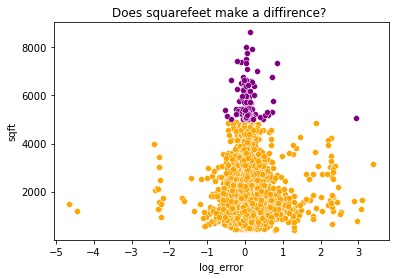

In [21]:
sns.scatterplot(y='sqft', x='log_error',
                data=train[train.sqft<= 5000], color='orange')

sns.scatterplot(y='sqft', x='log_error',
                data=train[train.sqft> 5000], 
                color='purple')

plt.title("Does squarefeet make a diffirence? ")
plt.show()

**Properties with less than 5,000 sqft seem to have more log error than houses above 5,000 sqft.**

In [22]:
# create bins
train['sqft_bin']= pd.cut(train.sqft,[0,5000,19000],labels = ['lessthan_5000sqft', 'morethan_5000sqft'])

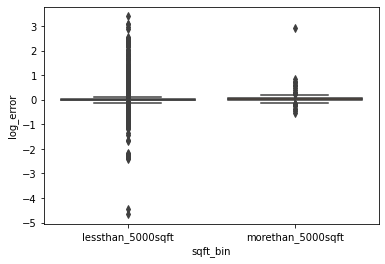

In [23]:
# box plot of the two groups and spending score
sns.boxplot(x=train.sqft_bin, y=train.log_error)
plt.show()

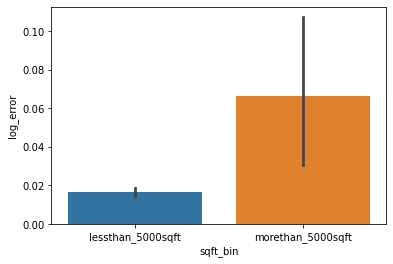

In [24]:
sns.barplot(x= train.sqft_bin, y= train.log_error);

Homes with less than 5000 sqft seem to have more log error.

In [25]:
train.sqft_bin.value_counts()

lessthan_5000sqft    27979
morethan_5000sqft      184
Name: sqft_bin, dtype: int64

In [26]:
stat, p_value = stats.levene(train[train.sqft_bin=='lessthan_5000sqft'].log_error, 
                             train[train.sqft_bin=='morethan_5000sqft'].log_error,)
stat, p_value

(13.30671236530635, 0.0002649346937823203)

$H_0$: Log_error of properties with less than 5000sqft >= Log_error mean of properties with more than 5000sqft

$H_a$: Log_error of properties with less than 5000sqft < Log_error mean of properties with more than 5000sqft

In [27]:
sample_less = train[train.sqft_bin=='lessthan_5000sqft']
sample_more = train[train.sqft_bin=='morethan_5000sqft']

alpha = 0.05
t, p = stats.ttest_ind(sample_less.log_error,sample_more.log_error,equal_var = True, random_state=123)

print(t, p/2)

-3.921261907723357 4.414752835727403e-05


**Since p/2 is less than 0.05 then we reject null hypothesis. So there is evidence to suggest that the log_error of properties with less than 5000 sqft is more than the log_error than propeties with more than 5000sqft.**

# Custering using price and size

### scale 1st

In [87]:
# the variables that still need scaling
columns_to_scale = ['bedrooms', 'bathrooms', 'age', 'sqft', 'lot_sqft', 'tax_value_bldg', 'tax_value', 'tax_value_land',
       'taxamount','yearbuilt']

In [88]:
train_scaled, X_validate_scaled,X_test_scaled = w.scale_data(train,X_validate, X_test, columns_to_scale, MinMaxScaler())

In [89]:
train_scaled

,parcelid,bedrooms,bathrooms,calculatedbathnbr,fullbathcnt,age,yearbuilt,has_basement,has_deck,has_fireplace,...,censustractandblock,sqft,lot_sqft,tax_value_bldg,tax_value,tax_value_land,taxamount,log_error,logerror_bin,sqft_bin
46594,12741442,0.285714,0.142857,2.0,2.0,0.437037,0.562963,0,0,0,...,6.037552e+13,0.103608,0.000758,0.064886,0.162419,0.117690,0.067209,0.037870,"(-0.5, 0.5]",lessthan_5000sqft
5692,11283097,0.428571,0.142857,2.0,2.0,0.200000,0.800000,0,0,0,...,6.037901e+13,0.158337,0.000985,0.089969,0.097867,0.025667,0.051068,0.122093,"(-0.5, 0.5]",lessthan_5000sqft
41034,14262082,0.285714,0.071429,1.5,1.0,0.422222,0.577778,0,0,0,...,6.059074e+13,0.097635,0.000850,0.029173,0.063975,0.043399,0.026866,0.075170,"(-0.5, 0.5]",lessthan_5000sqft
17083,12050297,0.142857,0.000000,1.0,1.0,0.659259,0.340741,0,0,0,...,6.037301e+13,0.096416,0.000945,0.016688,0.032515,0.020614,0.011426,-0.050191,"(-0.5, 0.5]",lessthan_5000sqft
31106,12689873,0.428571,0.571429,5.0,5.0,0.185185,0.814815,0,0,0,...,6.037670e+13,0.506948,0.002060,0.293348,0.958265,0.772082,0.359568,0.077013,"(-0.5, 0.5]",lessthan_5000sqft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45242,12718148,0.285714,0.000000,1.0,1.0,0.459259,0.540741,0,0,0,...,6.037503e+13,0.078864,0.000704,0.024237,0.033588,0.015031,0.021012,0.026142,"(-0.5, 0.5]",lessthan_5000sqft
11882,12040330,0.285714,0.000000,1.0,1.0,0.496296,0.503704,0,0,0,...,6.037300e+13,0.095563,0.000772,0.069312,0.285733,0.246744,0.099514,-0.030627,"(-0.5, 0.5]",lessthan_5000sqft
3384,10858066,0.142857,0.000000,1.0,1.0,0.496296,0.503704,0,0,0,...,6.037141e+13,0.078255,0.001084,0.025388,0.068737,0.051915,0.028483,0.208652,"(-0.5, 0.5]",lessthan_5000sqft
28632,10866967,0.714286,0.857143,7.0,7.0,0.414815,0.585185,0,0,0,...,6.037140e+13,0.555583,0.001291,0.407938,0.845649,0.548293,0.331053,0.088304,"(-0.5, 0.5]",lessthan_5000sqft


# Taxamount _____what i am clustering on price and size

In [90]:
# list of variables I will cluster on. 
cluster_vars = ['taxamount', 'sqft', 'lot_sqft']
cluster_name = 'price_and_size_cluster'


In [91]:
X_price_and_size_cluster = train_scaled[['taxamount', 'sqft', 'lot_sqft']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_price_and_size_cluster)
train_scaled['cluster'] = kmeans.predict(X_price_and_size_cluster)
centroids= pd.DataFrame(kmeans.cluster_centers_, columns=X_price_and_size_cluster.columns)

centroids

,taxamount,sqft,lot_sqft
0,0.081819,0.189402,0.001563
1,0.155048,0.289510,0.001912
2,0.053737,0.099338,0.001162
3,0.239476,0.466422,0.003220


In [92]:
train_scaled.cluster

46594    2
5692     0
41034    2
17083    2
31106    3
        ..
45242    2
11882    2
3384     2
28632    3
27910    0
Name: cluster, Length: 28163, dtype: int32

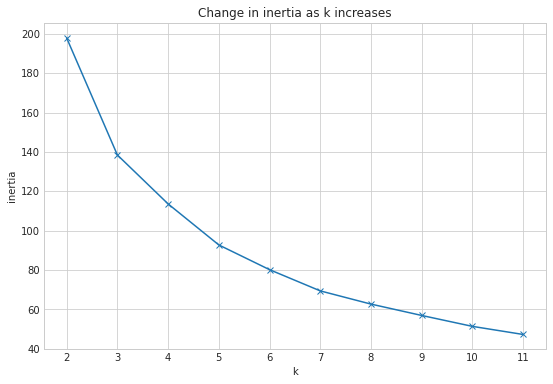

In [83]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_price_and_size_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

k of interest 3, 4, and 5

Text(0.5, 1.0, 'Visualizing Cluster Centers')

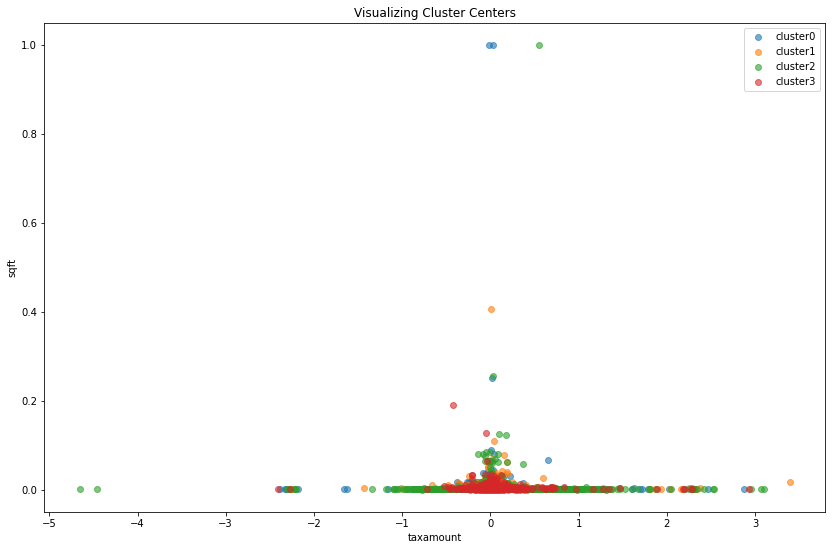

In [97]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.log_error, subset.lot_sqft, label='cluster' + str(cluster), alpha=.6)

#centroids.plot.scatter(x='taxamount', y='lot_sqft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('taxamount')
plt.ylabel('sqft')
plt.title('Visualizing Cluster Centers')

In [95]:
train_scaled.log_error

46594    0.037870
5692     0.122093
41034    0.075170
17083   -0.050191
31106    0.077013
           ...   
45242    0.026142
11882   -0.030627
3384     0.208652
28632    0.088304
27910   -0.094011
Name: log_error, Length: 28163, dtype: float64

Text(0.5, 1.0, 'Visualizing Cluster Centers')

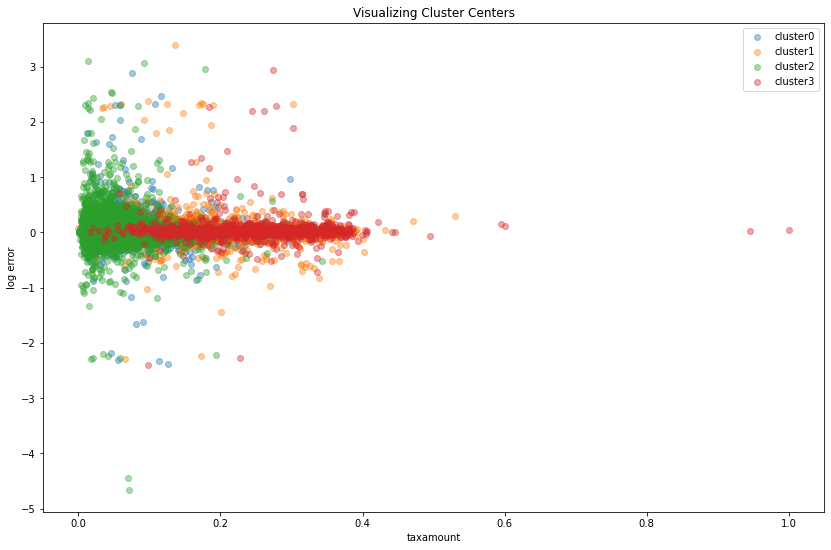

In [103]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(x=subset.taxamount, y=subset.log_error, label='cluster' + str(cluster), alpha=.4)

#centroids.plot.scatter(x='taxamount', y='log_error', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('taxamount')
plt.ylabel('log error')
plt.title('Visualizing Cluster Centers')

In [106]:
train_scaled.cluster.value_counts()


2    13112
0     9254
1     4522
3     1275
Name: cluster, dtype: int64

# question? Is there a Relationship between green cluster and log error

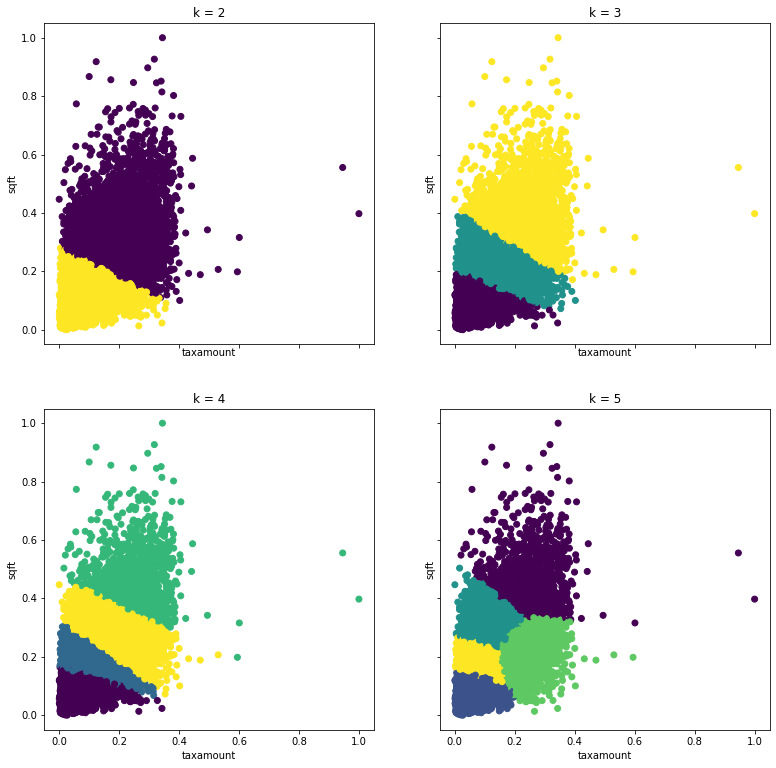

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_price_and_size_cluster).predict(X_price_and_size_cluster)
    ax.scatter(X_price_and_size_cluster.taxamount, X_price_and_size_cluster.sqft, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='taxamount', ylabel='sqft')

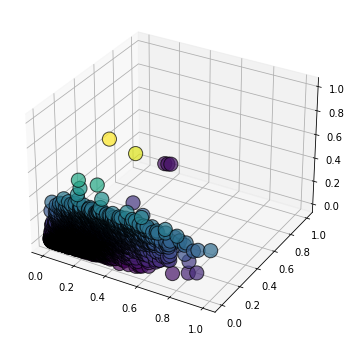

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = X_price_and_size_cluster.sqft
y = X_price_and_size_cluster.lot_sqft
z = X_price_and_size_cluster.taxamount


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

In [ ]:
train.tax_value

# Tax_value ______what i am clustering on price and size

In [109]:
# list of variables I will cluster on. 
cluster_vars = ['tax_value', 'sqft', 'lot_sqft']
cluster_name = 'price_and_size_cluster'


In [110]:
X_tax_value = train_scaled[['tax_value', 'sqft', 'lot_sqft']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_price_and_size_cluster)
train_scaled['cluster2'] = kmeans.predict(X_tax_value )
centroids2= pd.DataFrame(kmeans.cluster_centers_, columns=X_tax_value.columns)

centroids2

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- tax_value
Feature names seen at fit time, yet now missing:
- taxamount

  warnings.warn(message, FutureWarning)


,tax_value,sqft,lot_sqft
0,0.081057,0.187563,0.001672
1,0.153286,0.287311,0.001896
2,0.053508,0.098667,0.001079
3,0.238364,0.463846,0.003184


In [111]:
train_scaled.cluster2

46594    2
5692     0
41034    2
17083    2
31106    3
        ..
45242    2
11882    0
3384     2
28632    3
27910    0
Name: cluster2, Length: 28163, dtype: int32

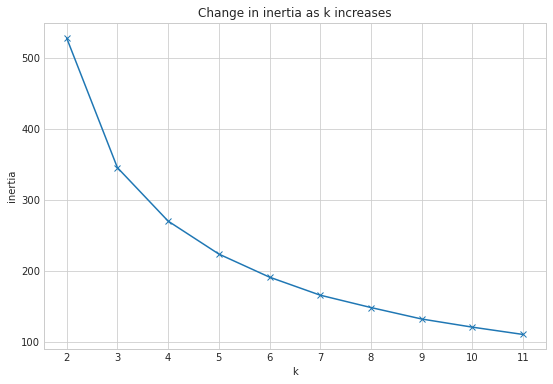

In [112]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_tax_value).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

k of interest 3, 4, and 5

Text(0.5, 1.0, 'Visualizing Cluster Centers')

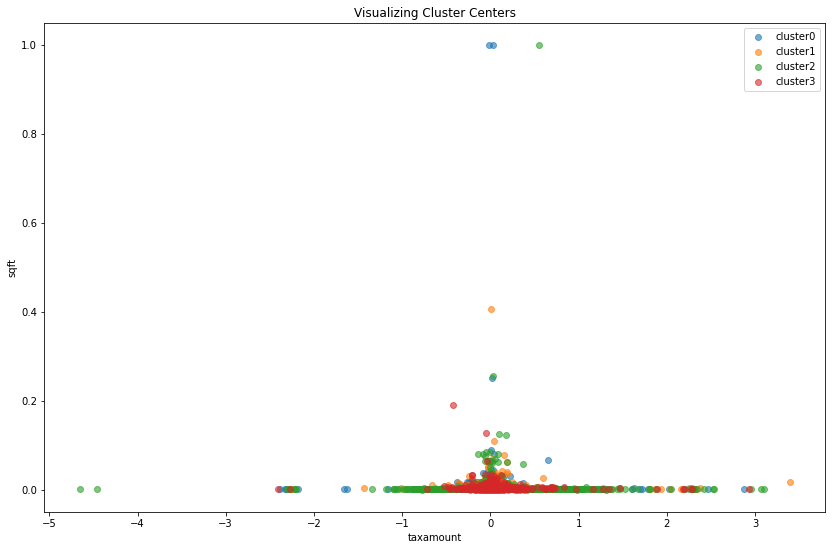

In [97]:
plt.figure(figsize=(14, 9))

for cluster2, subset in train_scaled.groupby('cluster2'):
    plt.scatter(subset.tax_value, subset.lot_sqft, label='cluster2' + str(cluster2), alpha=.6)

centroids.plot.scatter(x='tax_value', y='lot_sqft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('taxamount')
plt.ylabel('sqft')
plt.title('Visualizing Cluster Centers')

In [95]:
train_scaled.log_error

46594    0.037870
5692     0.122093
41034    0.075170
17083   -0.050191
31106    0.077013
           ...   
45242    0.026142
11882   -0.030627
3384     0.208652
28632    0.088304
27910   -0.094011
Name: log_error, Length: 28163, dtype: float64

Text(0.5, 1.0, 'Visualizing Cluster Centers')

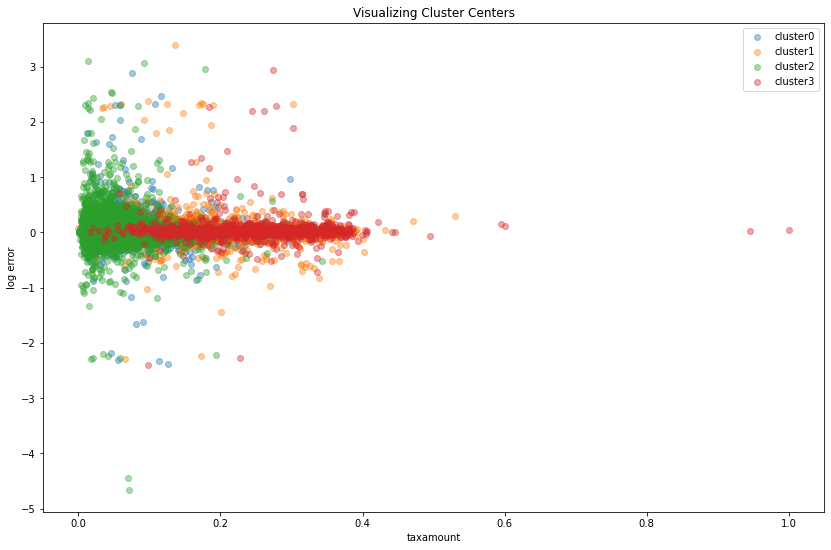

In [103]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(x=subset.taxamount, y=subset.log_error, label='cluster' + str(cluster), alpha=.4)

#centroids.plot.scatter(x='taxamount', y='log_error', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('taxamount')
plt.ylabel('log error')
plt.title('Visualizing Cluster Centers')

In [106]:
train_scaled.cluster.value_counts()


2    13112
0     9254
1     4522
3     1275
Name: cluster, dtype: int64

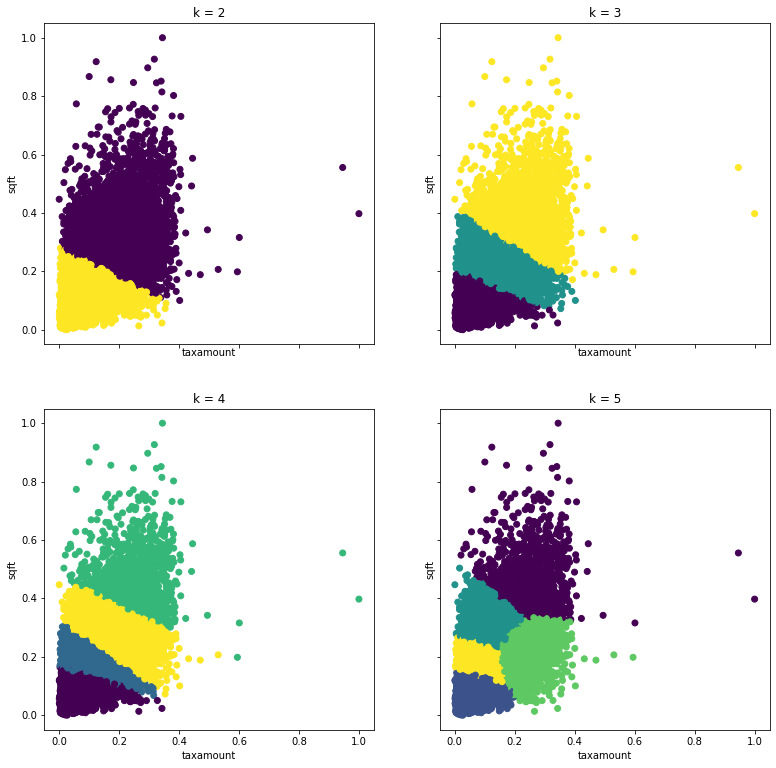

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_price_and_size_cluster).predict(X_price_and_size_cluster)
    ax.scatter(X_price_and_size_cluster.taxamount, X_price_and_size_cluster.sqft, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='taxamount', ylabel='sqft')

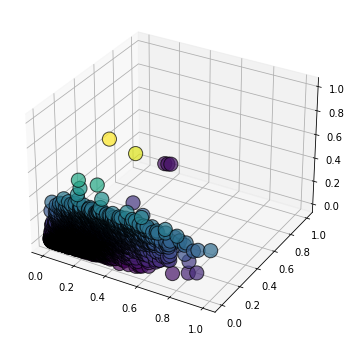

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = X_price_and_size_cluster.sqft
y = X_price_and_size_cluster.lot_sqft
z = X_price_and_size_cluster.taxamount


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

find_k(X_train, cluster_vars, k_range)

K values of interest  3, 4, 5, 6,

k = 3

cluster_vars = ['taxamount', 'sqft', 'lot_sqft']
cluster_name = 'price_and_size_cluster'

X_price_and_size_cluster = [['taxamount', 'sqft', 'lot_sqft']]

def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans

kmeans = create_clusters(X_train, k, cluster_vars)

# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df

centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)
centroid_df

# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

X = [X_train, X_validate, X_test]

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df, X):
    for i in range(len(X)):
        clusters = pd.DataFrame(kmeans.predict(X[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        X[i] = pd.concat([X[i], clusters_centroids], axis=1)
    return X

X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df, X)

X[0].head()

X_price_and_size_cluster = train[['taxamount', 'sqft', 'lot_sqft']]

fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_price_and_size_cluster).predict(X_price_and_size_cluster)
    ax.scatter(X_price_and_size_cluster.taxamount, X_price_and_size_cluster.sqft, c=clusters,alpha=.2)
    ax.set(title='k = {}'.format(k), xlabel='taxamount', ylabel='sqft')


fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_price_and_size_cluster).predict(X_price_and_size_cluster)
    ax.scatter(X_price_and_size_cluster.taxamount, X_price_and_size_cluster.lot_sqft, c=clusters,alpha=.2)
    ax.set(title='k = {}'.format(k), xlabel='taxamount', ylabel='sqft')

*********************************END TRASH************************************

# Question 2: Is there more log_error in Older homes?


In [ ]:
train.yearbuilt.describe()

In [ ]:
sns.histplot(train.yearbuilt)

In [ ]:
sns.scatterplot(y='yearbuilt', x='log_error',
                data=train[train.yearbuilt<= 1935], color='orange')

sns.scatterplot(y='yearbuilt', x='log_error',
                data=train[(train.yearbuilt> 1935) & (train.yearbuilt<=1950)], 
                color='purple')
sns.scatterplot(y='yearbuilt', x='log_error',
                data=train[(train.yearbuilt> 1950) & (train.yearbuilt<1979)], 
                color='blue')
sns.scatterplot(y='yearbuilt', x='log_error',
                data=train[train.yearbuilt>1979], 
                color='brown')

plt.title("Does yearbuilt  make a diffirence? ")
plt.show()

**Yearbuilt does not seem to be an indicator of log_error with current bins. There is error in all ages more so in the years 1940 and above. Maybe if bins where distributed diffirently could lead to new discovery**

In [ ]:
sns.scatterplot(y='yearbuilt', x='log_error',
                data=train[train.yearbuilt<= 1935], color='orange')

sns.scatterplot(y='yearbuilt', x='log_error',
                data=train[train.yearbuilt> 1935], 
                color='purple')


plt.title("Does yearbuilt  make a diffirence? ")
plt.show()

In [ ]:
train['yearbuilt_bins'] = pd.cut(train.yearbuilt, [0,1935,2020],labels = ['homes_lessthan_1935', 'homes_morethan_1935'])


In [ ]:
train.yearbuilt_bins.value_counts()

In [ ]:
sns.barplot(x= train.yearbuilt_bins, y= train.log_error);

In [ ]:
stat, p_value = stats.levene(train[train.yearbuilt_bins=='homes_morethan_1935'].log_error, 
                             train[train.yearbuilt_bins=='homes_lessthan_1935'].log_error)
stat, p_value

$H_0$: Log_error of properties whose yearbuilt is less or equal than 1935 >= Log_error mean of properties whose yearbuilt is more than 1935

$H_a$: Log_error of properties whose yearbuilt is less or equal than 1935 < Log_error mean of properties whose yearbuilt is more than 1935

In [ ]:
sample_more = train[train.yearbuilt_bins=='homes_morethan_1935']
sample_less= train[train.yearbuilt_bins=='homes_lessthan_1935']

alpha = 0.05
t, p = stats.ttest_ind(sample_less.log_error,sample_more.log_error,equal_var = True, random_state=123)

print(t, p/2)

We reject the null hypotheis. There is evidence to suggest that the mean log error of properties whose yearbuilt is below 1935 is mless than log error of homes built after 1935

In [ ]:
train.fips

# Question 3 longitute vs latitude log error

In [ ]:
sns.scatterplot(x=train.longitude, y=train.latitude,hue=train.log_error)